In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.80

verbose = False
paperpath = "./data/particulate.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wso2_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   genova
   2   pavia
   3   bat
   4   frosinone
   5   pisa
   6   ravenna
   7   savona
   8   parma
   9   massa
   10   trieste
   11   pescara
   12   pistoia
   13   verbania
   14   caltanissetta
   15   fermo
   16   rovigo
   17   udine
   18   bergamo
   19   messina
   20   macerata
   21   sassari
   22   perugia
   23   vercelli
   24   agrigento
   25   ascoli_piceno
   26   brindisi
   27   napoli
   28   gorizia
   29   lodi
   30   matera
   31   reggio_di_calabria
   32   enna
   33   treviso
   34   siena
   35   livorno
   36   foggia
   37   cremona
   38   avellino
   39   chieti
   40   firenze
   41   isernia
   42   crotone
   43   padova
   44   bologna
   45   carbonia
   46   cuneo
   47   caserta
   48   lucca
   49   asti
   50   salerno
   51   mantova
   52   modena
   53   l_aquila
   54   milano
   55   cosenza
   56   alessandria
   57   benevento
   58   lecco
   59   bol

In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
           ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 genova
2 pavia
3 bat
4 frosinone
5 pisa
6 ravenna
7 savona
8 parma
9 massa
10 trieste
11 pescara
12 pistoia
13 verbania
14 caltanissetta
15 fermo
16 rovigo
17 udine
18 bergamo
19 messina
20 macerata
21 sassari
22 perugia
23 vercelli
24 agrigento
25 ascoli_piceno
26 brindisi
27 napoli
28 gorizia
29 lodi
30 matera
31 reggio_di_calabria
32 enna
33 treviso
34 siena
35 livorno
36 foggia
37 cremona
38 avellino
39 chieti
40 firenze
41 crotone
42 padova
43 bologna
44 cuneo
45 caserta
46 lucca
47 asti
48 salerno
49 mantova
50 modena
51 l_aquila
52 milano
53 cosenza
54 alessandria
55 benevento
56 lecco
57 bolzano
58 novara
59 la_spezia
60 forli
61 vibo_valentia
62 trapani
63 potenza
64 catanzaro
65 monza
66 prato
67 teramo
68 belluno
69 rimini
70 como
71 roma
72 venezia
73 campobasso
74 arezzo
75 brescia
76 trento
77 bari
78 lecce
79 pordenone
80 catania
81 sondrio
82 pesaro
83 oristano
84 grosseto
85 verona
86 ancona
87 ragusa
88 nuoro
89 torino
90 biella
91 varese
92 terni
93 latina
94 reggi

In [4]:
#add random feature
import random

featurestobeused += ",randomfeature"
features_dict["randomfeature"] = np.zeros(len(ylogpropcasi), dtype="float64")

random.seed(1)
for i in range(len(ylogpropcasi)):
    features_dict["randomfeature"][i] = random.random()


In [5]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    if len(highcorrelated[v1]) > 0:
        print(v1)
        for fntr in highcorrelated[v1]:
            print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.

Training set average RMSE:  0.35355  0.02626 
    Test set average RMSE:  0.95468  0.10302 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.34273
                       R2:  0.94625


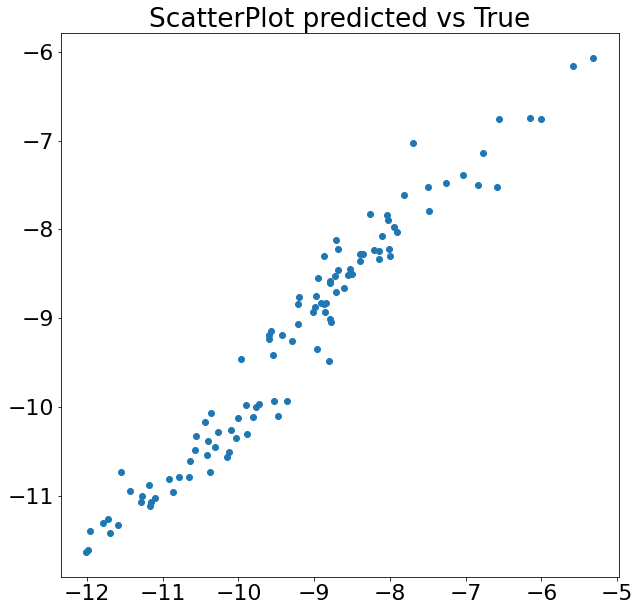

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.02717
Feature:               commutersdensity, Score: 0.02164
Feature:                         depriv, Score: 0.02440
Feature:                            lat, Score: 0.64356
Feature:                 Ratio0200ver65, Score: 0.04541
Feature:         avg_wpm10_period1_2020, Score: 0.07089
Feature:           avg_wno_period1_2020, Score: 0.06231
Feature:         avg_wpans_period1_2020, Score: 0.02726
Feature:          avg_wso2_period1_2020, Score: 0.01811
Feature:                  randomfeature, Score: 0.05924


<Figure size 432x288 with 0 Axes>

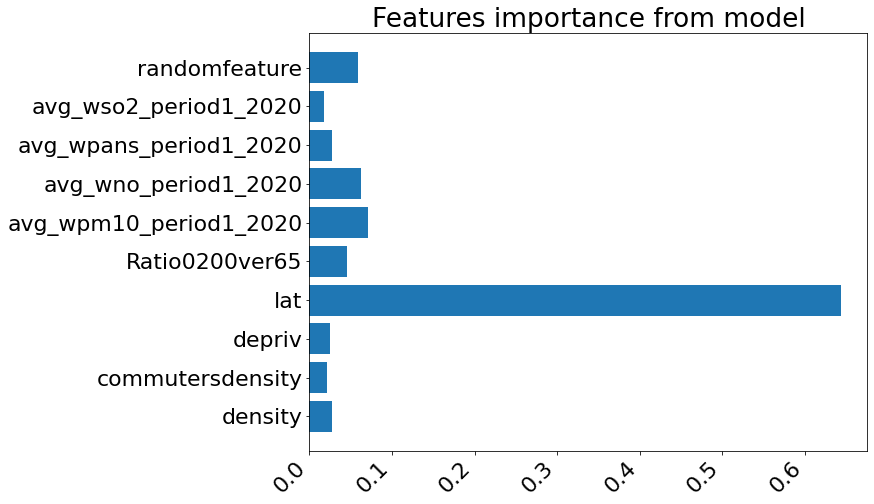

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04984 +/- 0.00625
Feature:               commutersdensity, Score: 0.02115 +/- 0.00315
Feature:                         depriv, Score: 0.04351 +/- 0.00408
Feature:                            lat, Score: 2.86171 +/- 0.34625
Feature:                 Ratio0200ver65, Score: 0.11652 +/- 0.01657
Feature:         avg_wpm10_period1_2020, Score: 0.13729 +/- 0.01485
Feature:           avg_wno_period1_2020, Score: 0.15003 +/- 0.01733
Feature:         avg_wpans_period1_2020, Score: 0.04058 +/- 0.00414
Feature:          avg_wso2_period1_2020, Score: 0.04720 +/- 0.00715
Feature:                  randomfeature, Score: 0.16112 +/- 0.02315


<Figure size 432x288 with 0 Axes>

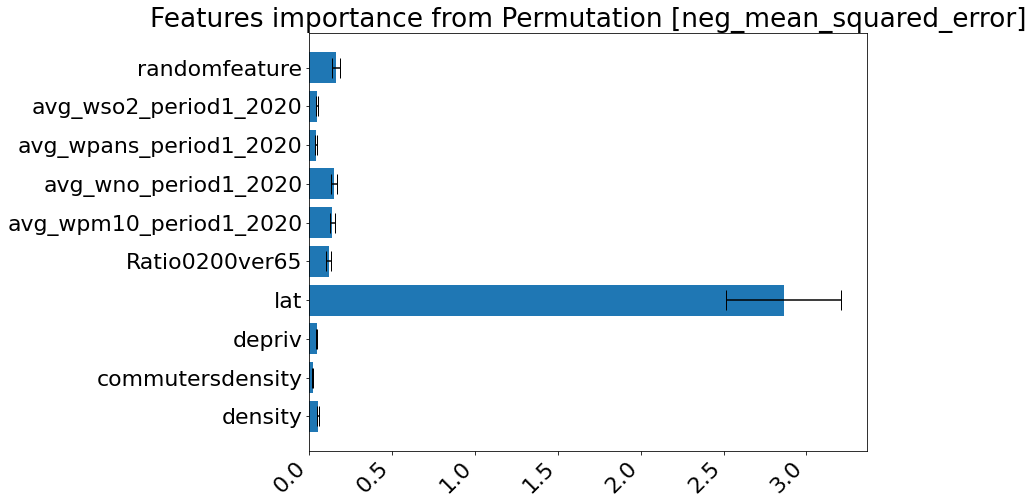

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.02281 +/- 0.00286
Feature:               commutersdensity, Score: 0.00968 +/- 0.00144
Feature:                         depriv, Score: 0.01991 +/- 0.00187
Feature:                            lat, Score: 1.30956 +/- 0.15845
Feature:                 Ratio0200ver65, Score: 0.05332 +/- 0.00758
Feature:         avg_wpm10_period1_2020, Score: 0.06283 +/- 0.00679
Feature:           avg_wno_period1_2020, Score: 0.06866 +/- 0.00793
Feature:         avg_wpans_period1_2020, Score: 0.01857 +/- 0.00190
Feature:          avg_wso2_period1_2020, Score: 0.02160 +/- 0.00327
Feature:                  randomfeature, Score: 0.07373 +/- 0.01059


<Figure size 432x288 with 0 Axes>

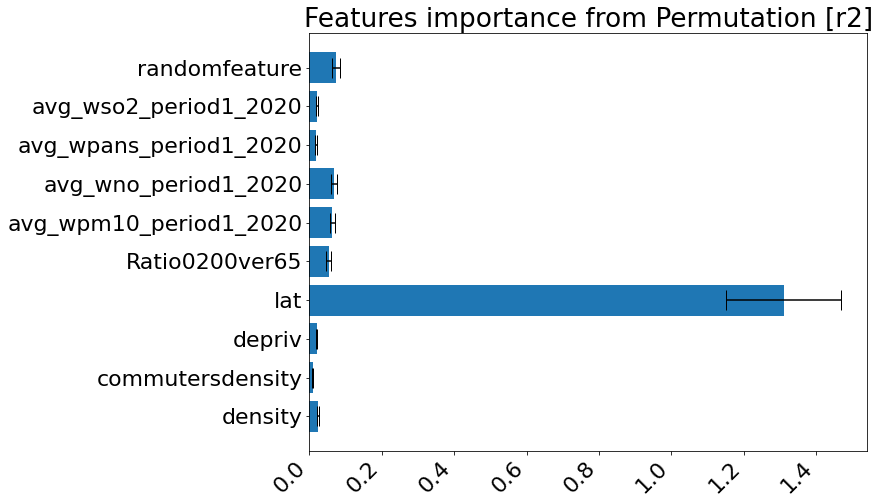

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: -0.02393 +/- 0.02041
Feature:               commutersdensity, Score: 0.03608 +/- 0.01130
Feature:                         depriv, Score: 0.01711 +/- 0.01494
Feature:                            lat, Score: 1.91742 +/- 0.54557
Feature:                 Ratio0200ver65, Score: 0.06519 +/- 0.04025
Feature:         avg_wpm10_period1_2020, Score: -0.03609 +/- 0.01748
Feature:           avg_wno_period1_2020, Score: 0.00781 +/- 0.03646
Feature:         avg_wpans_period1_2020, Score: 0.01449 +/- 0.01408
Feature:          avg_wso2_period1_2020, Score: -0.00940 +/- 0.01569
Feature:                  randomfeature, Score: -0.04012 +/- 0.05311


<Figure size 432x288 with 0 Axes>

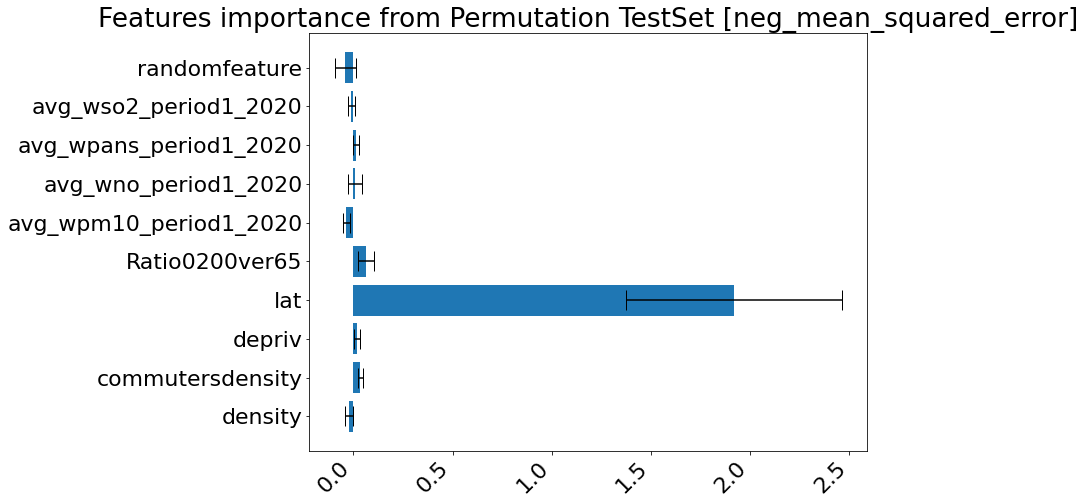

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: -0.01919 +/- 0.01637
Feature:               commutersdensity, Score: 0.02893 +/- 0.00906
Feature:                         depriv, Score: 0.01372 +/- 0.01198
Feature:                            lat, Score: 1.53748 +/- 0.43747
Feature:                 Ratio0200ver65, Score: 0.05228 +/- 0.03228
Feature:         avg_wpm10_period1_2020, Score: -0.02894 +/- 0.01402
Feature:           avg_wno_period1_2020, Score: 0.00626 +/- 0.02923
Feature:         avg_wpans_period1_2020, Score: 0.01162 +/- 0.01129
Feature:          avg_wso2_period1_2020, Score: -0.00754 +/- 0.01258
Feature:                  randomfeature, Score: -0.03217 +/- 0.04259


<Figure size 432x288 with 0 Axes>

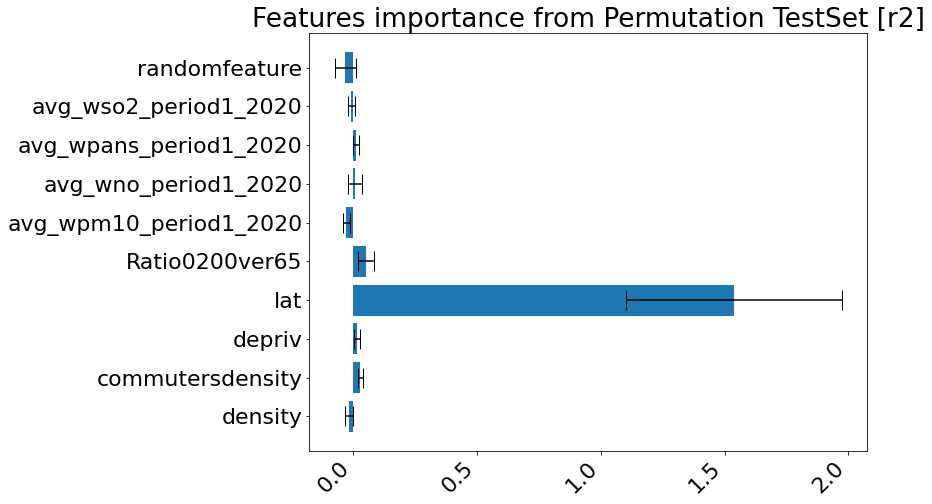

<Figure size 720x720 with 0 Axes>

((0.35355025839916243, 0.026264721703345276),
 (0.9546820530980226, 0.10302015771633746),
 0.3427295780535301,
 {'density': 0.01373273733577806,
  'commutersdensity': 0.005828400542469335,
  'depriv': 0.011989680187240524,
  'lat': 0.7885784885312198,
  'Ratio0200ver65': 0.032108226738023306,
  'avg_wpm10_period1_2020': 0.03783222097430775,
  'avg_wno_period1_2020': 0.04134376469392154,
  'avg_wpans_period1_2020': 0.011181603175423499,
  'avg_wso2_period1_2020': 0.013006551550855337,
  'randomfeature': 0.04439832627076087},
 {'density': 0.013732737335778065,
  'commutersdensity': 0.005828400542469334,
  'depriv': 0.011989680187240524,
  'lat': 0.7885784885312199,
  'Ratio0200ver65': 0.032108226738023306,
  'avg_wpm10_period1_2020': 0.03783222097430775,
  'avg_wno_period1_2020': 0.04134376469392153,
  'avg_wpans_period1_2020': 0.011181603175423502,
  'avg_wso2_period1_2020': 0.013006551550855335,
  'randomfeature': 0.04439832627076087},
 {'density': -0.012280131682837286,
  'commutersde

In [6]:
#finalfeaturestobeused = "density,commutersdensity,exoverstation"
#features = finalfeaturestobeused.split(",")
#listostack = [features_dict[v] for v in features]
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_allfeatures", showplot=True)

In [7]:
# here we test grid opt to get a model not overfitting 

importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = smlmodule.rfregressors_custom_optimizer_nooverfit (X, Y, inboot=[True])

print(besthyperF, best_diff, best_test_rmse, best_train_rmse)

1  of  1200 Train RMSE:  0.34673635624469534
1  of  1200  Test RMSE:  0.9156787686893044
2  of  1200 Train RMSE:  0.33912054371870526
2  of  1200  Test RMSE:  0.918861942871251
3  of  1200 Train RMSE:  0.4204195859674945
3  of  1200  Test RMSE:  0.9191638767853929
4  of  1200 Train RMSE:  0.46092148300316843
4  of  1200  Test RMSE:  0.9219326308819145
5  of  1200 Train RMSE:  0.6272100254824825
5  of  1200  Test RMSE:  0.9197202418555246
6  of  1200 Train RMSE:  0.6940991922989471
6  of  1200  Test RMSE:  0.9175265393908361
7  of  1200 Train RMSE:  0.7815488466509928
7  of  1200  Test RMSE:  0.860917902461038
8  of  1200 Train RMSE:  0.8393203585801691
8  of  1200  Test RMSE:  0.900619204997939
9  of  1200 Train RMSE:  0.40530517000619565
9  of  1200  Test RMSE:  0.9193198960713034
10  of  1200 Train RMSE:  0.4282004403837744
10  of  1200  Test RMSE:  0.9256343009502981
11  of  1200 Train RMSE:  0.4456554706627891
11  of  1200  Test RMSE:  0.9223503255968897
12  of  1200 Train RMSE:  0

Training set average RMSE:  0.34842  0.02613 
    Test set average RMSE:  0.97127  0.09488 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.34273
                       R2:  0.94625


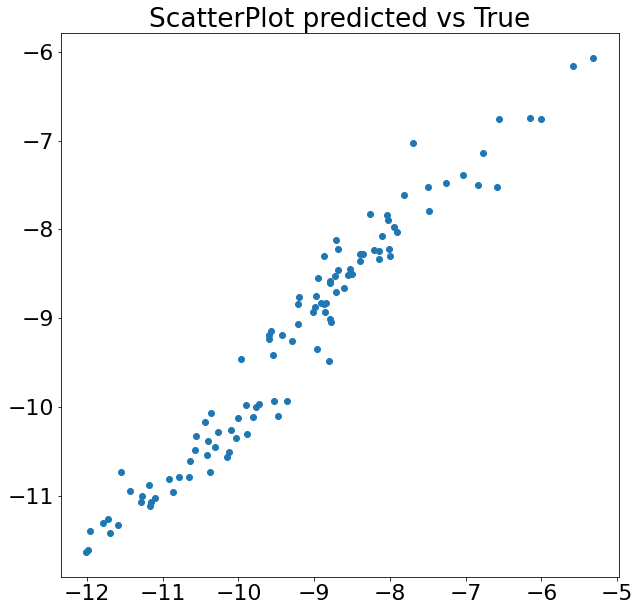

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.02717
Feature:               commutersdensity, Score: 0.02164
Feature:                         depriv, Score: 0.02440
Feature:                            lat, Score: 0.64356
Feature:                 Ratio0200ver65, Score: 0.04541
Feature:         avg_wpm10_period1_2020, Score: 0.07089
Feature:           avg_wno_period1_2020, Score: 0.06231
Feature:         avg_wpans_period1_2020, Score: 0.02726
Feature:          avg_wso2_period1_2020, Score: 0.01811
Feature:                  randomfeature, Score: 0.05924


<Figure size 432x288 with 0 Axes>

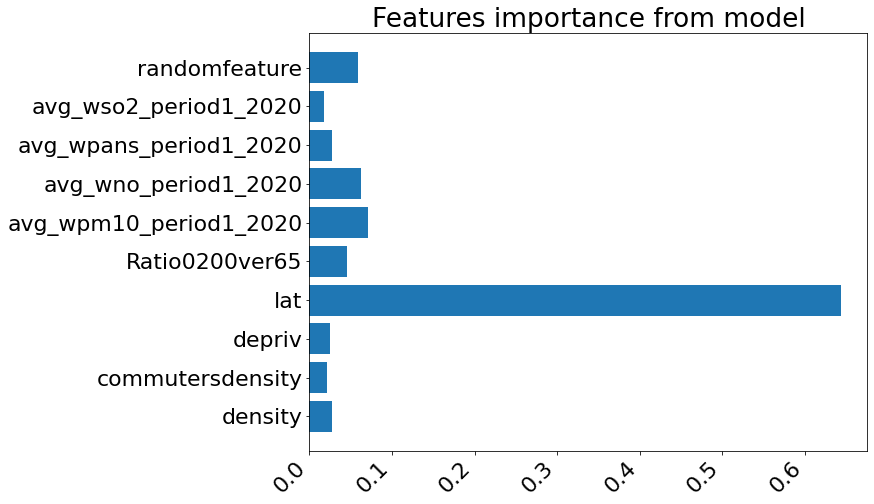

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04695 +/- 0.00648
Feature:               commutersdensity, Score: 0.02512 +/- 0.00348
Feature:                         depriv, Score: 0.04744 +/- 0.00487
Feature:                            lat, Score: 2.82721 +/- 0.33639
Feature:                 Ratio0200ver65, Score: 0.11235 +/- 0.01529
Feature:         avg_wpm10_period1_2020, Score: 0.12642 +/- 0.01240
Feature:           avg_wno_period1_2020, Score: 0.15420 +/- 0.01739
Feature:         avg_wpans_period1_2020, Score: 0.04741 +/- 0.00472
Feature:          avg_wso2_period1_2020, Score: 0.04081 +/- 0.00524
Feature:                  randomfeature, Score: 0.18047 +/- 0.02604


<Figure size 432x288 with 0 Axes>

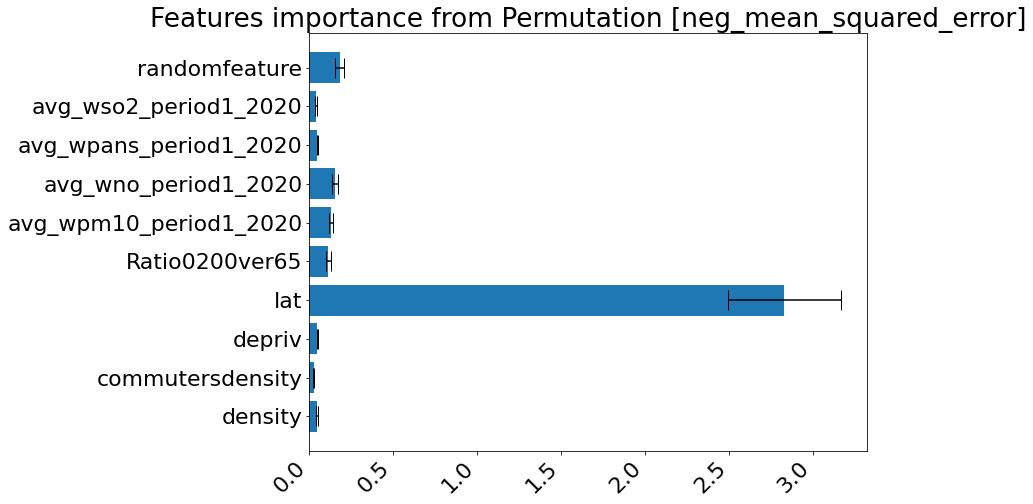

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.02149 +/- 0.00297
Feature:               commutersdensity, Score: 0.01150 +/- 0.00159
Feature:                         depriv, Score: 0.02171 +/- 0.00223
Feature:                            lat, Score: 1.29377 +/- 0.15394
Feature:                 Ratio0200ver65, Score: 0.05141 +/- 0.00700
Feature:         avg_wpm10_period1_2020, Score: 0.05785 +/- 0.00567
Feature:           avg_wno_period1_2020, Score: 0.07057 +/- 0.00796
Feature:         avg_wpans_period1_2020, Score: 0.02170 +/- 0.00216
Feature:          avg_wso2_period1_2020, Score: 0.01868 +/- 0.00240
Feature:                  randomfeature, Score: 0.08259 +/- 0.01192


<Figure size 432x288 with 0 Axes>

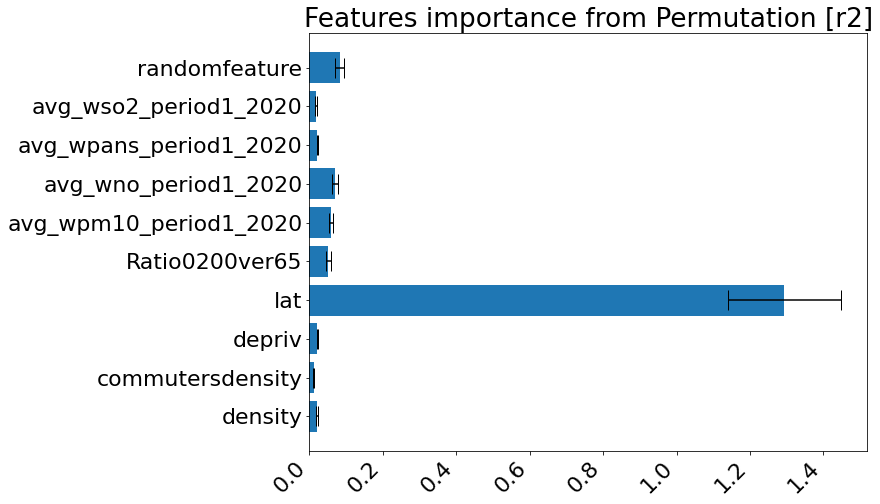

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: -0.05710 +/- 0.02464
Feature:               commutersdensity, Score: 0.01085 +/- 0.00483
Feature:                         depriv, Score: 0.00449 +/- 0.02168
Feature:                            lat, Score: 1.95684 +/- 0.56502
Feature:                 Ratio0200ver65, Score: -0.00056 +/- 0.05348
Feature:         avg_wpm10_period1_2020, Score: -0.02488 +/- 0.02124
Feature:           avg_wno_period1_2020, Score: 0.03426 +/- 0.04406
Feature:         avg_wpans_period1_2020, Score: -0.00099 +/- 0.01750
Feature:          avg_wso2_period1_2020, Score: -0.02946 +/- 0.01811
Feature:                  randomfeature, Score: -0.04632 +/- 0.04648


<Figure size 432x288 with 0 Axes>

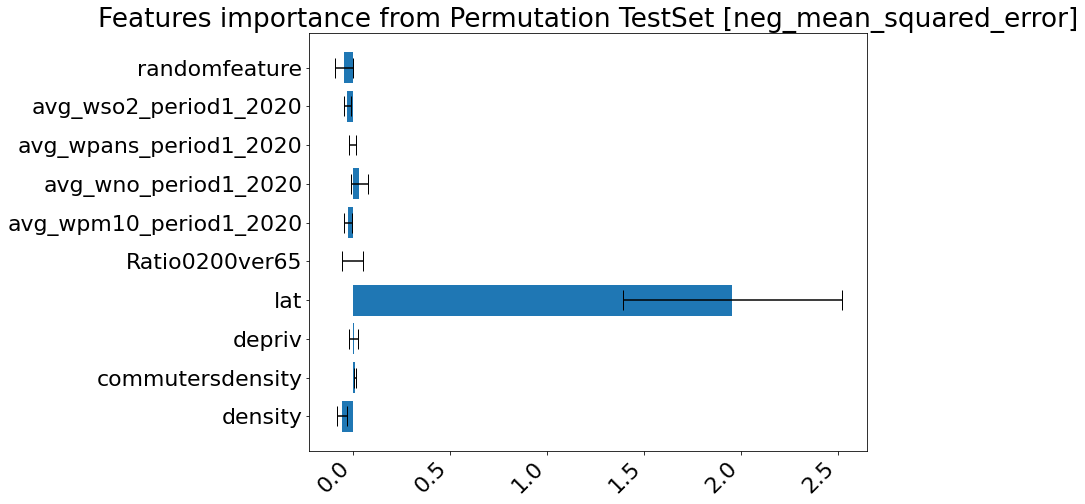

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: -0.04578 +/- 0.01976
Feature:               commutersdensity, Score: 0.00870 +/- 0.00387
Feature:                         depriv, Score: 0.00360 +/- 0.01738
Feature:                            lat, Score: 1.56909 +/- 0.45306
Feature:                 Ratio0200ver65, Score: -0.00045 +/- 0.04288
Feature:         avg_wpm10_period1_2020, Score: -0.01995 +/- 0.01703
Feature:           avg_wno_period1_2020, Score: 0.02747 +/- 0.03533
Feature:         avg_wpans_period1_2020, Score: -0.00080 +/- 0.01404
Feature:          avg_wso2_period1_2020, Score: -0.02362 +/- 0.01452
Feature:                  randomfeature, Score: -0.03714 +/- 0.03727


<Figure size 432x288 with 0 Axes>

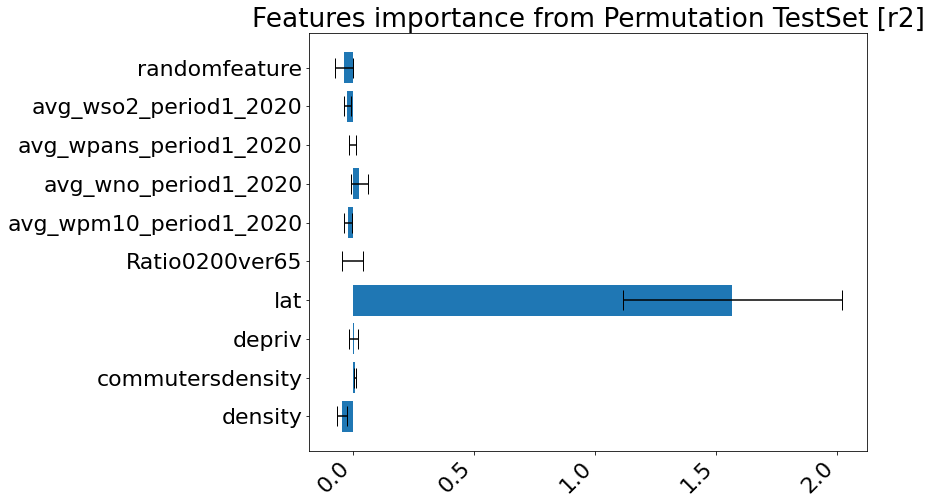

<Figure size 720x720 with 0 Axes>

((0.3484237191324698, 0.026128099229370975),
 (0.9712720721144271, 0.09488288478112672),
 0.3427295780535301,
 {'density': 0.01301159478091854,
  'commutersdensity': 0.006961523002225299,
  'depriv': 0.013148107239044497,
  'lat': 0.7835086903388834,
  'Ratio0200ver65': 0.03113623413053413,
  'avg_wpm10_period1_2020': 0.035034241692363036,
  'avg_wno_period1_2020': 0.04273482405650499,
  'avg_wpans_period1_2020': 0.013139743442955503,
  'avg_wso2_period1_2020': 0.01130980166461254,
  'randomfeature': 0.05001523965195819},
 {'density': 0.013011594780918513,
  'commutersdensity': 0.006961523002225272,
  'depriv': 0.013148107239044474,
  'lat': 0.7835086903388835,
  'Ratio0200ver65': 0.031136234130534117,
  'avg_wpm10_period1_2020': 0.03503424169236302,
  'avg_wno_period1_2020': 0.04273482405650499,
  'avg_wpans_period1_2020': 0.013139743442955477,
  'avg_wso2_period1_2020': 0.011309801664612514,
  'randomfeature': 0.05001523965195819},
 {'density': -0.030910693471944986,
  'commutersdens

In [11]:
import pprint

#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_allfeatures_opt", showplot=True, optimisedparams=besthyperF)

Training set average RMSE:  0.38956  0.02767 
    Test set average RMSE:  0.99194  0.08927 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.37090
                       R2:  0.93705


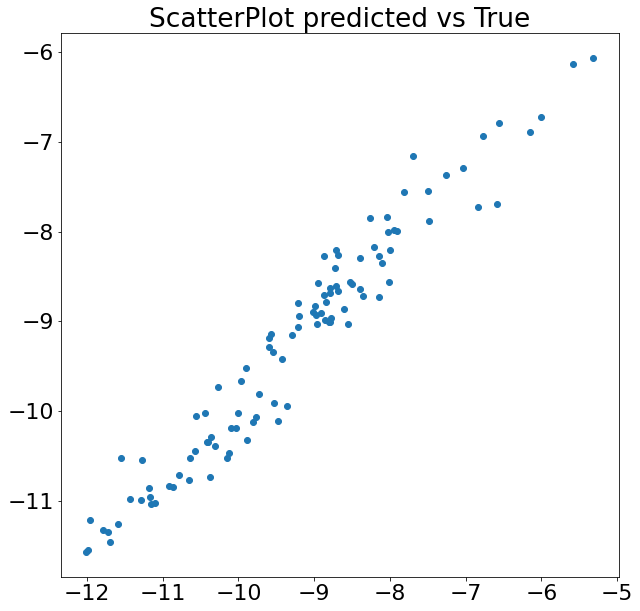

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.03559
Feature:               commutersdensity, Score: 0.45575
Feature:                         depriv, Score: 0.04408
Feature:                 Ratio0200ver65, Score: 0.08393
Feature:         avg_wpm10_period1_2020, Score: 0.09897
Feature:           avg_wno_period1_2020, Score: 0.14096
Feature:         avg_wpans_period1_2020, Score: 0.03814
Feature:          avg_wso2_period1_2020, Score: 0.02811
Feature:                  randomfeature, Score: 0.07447


<Figure size 432x288 with 0 Axes>

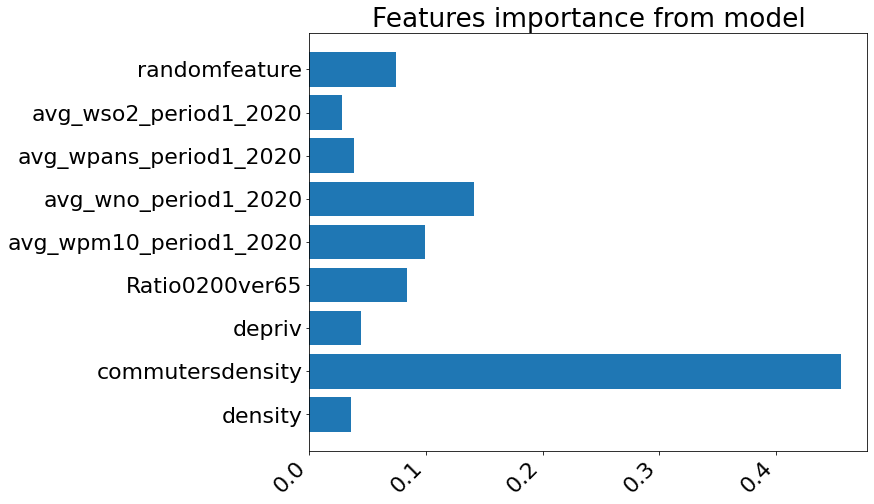

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.05511 +/- 0.00649
Feature:               commutersdensity, Score: 1.71983 +/- 0.28293
Feature:                         depriv, Score: 0.06009 +/- 0.00742
Feature:                 Ratio0200ver65, Score: 0.19741 +/- 0.02569
Feature:         avg_wpm10_period1_2020, Score: 0.22935 +/- 0.03072
Feature:           avg_wno_period1_2020, Score: 0.27403 +/- 0.03119
Feature:         avg_wpans_period1_2020, Score: 0.07147 +/- 0.01098
Feature:          avg_wso2_period1_2020, Score: 0.06891 +/- 0.00652
Feature:                  randomfeature, Score: 0.18102 +/- 0.02634


<Figure size 432x288 with 0 Axes>

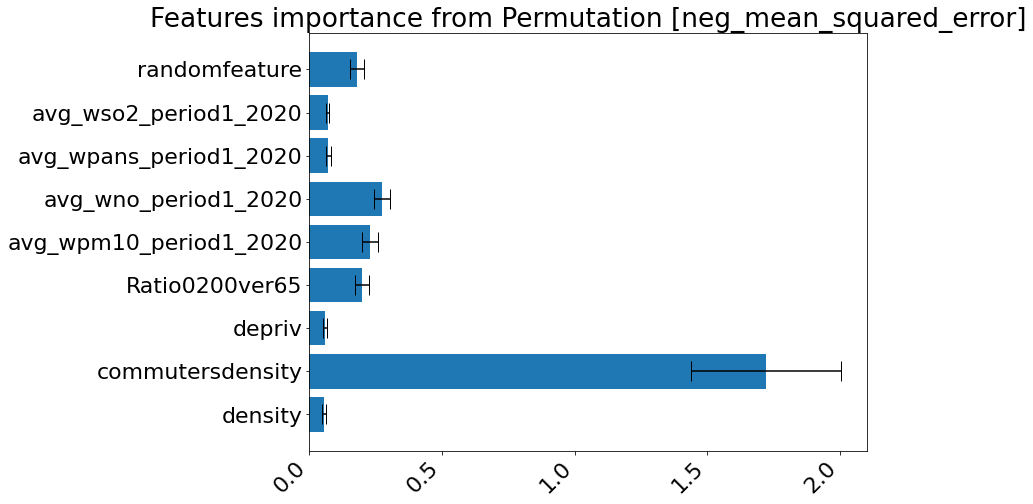

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.02522 +/- 0.00297
Feature:               commutersdensity, Score: 0.78702 +/- 0.12947
Feature:                         depriv, Score: 0.02750 +/- 0.00339
Feature:                 Ratio0200ver65, Score: 0.09034 +/- 0.01176
Feature:         avg_wpm10_period1_2020, Score: 0.10495 +/- 0.01406
Feature:           avg_wno_period1_2020, Score: 0.12540 +/- 0.01427
Feature:         avg_wpans_period1_2020, Score: 0.03271 +/- 0.00503
Feature:          avg_wso2_period1_2020, Score: 0.03154 +/- 0.00299
Feature:                  randomfeature, Score: 0.08284 +/- 0.01206


<Figure size 432x288 with 0 Axes>

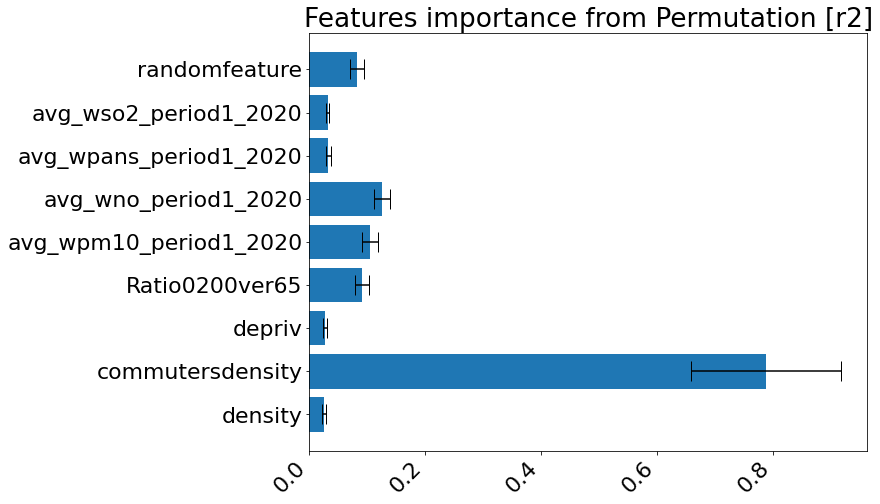

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: -0.03697 +/- 0.02215
Feature:               commutersdensity, Score: 1.10631 +/- 0.29133
Feature:                         depriv, Score: 0.02741 +/- 0.01803
Feature:                 Ratio0200ver65, Score: 0.01321 +/- 0.07137
Feature:         avg_wpm10_period1_2020, Score: -0.06521 +/- 0.02840
Feature:           avg_wno_period1_2020, Score: 0.12248 +/- 0.12250
Feature:         avg_wpans_period1_2020, Score: 0.02978 +/- 0.02862
Feature:          avg_wso2_period1_2020, Score: -0.03479 +/- 0.01329
Feature:                  randomfeature, Score: 0.06050 +/- 0.07082


<Figure size 432x288 with 0 Axes>

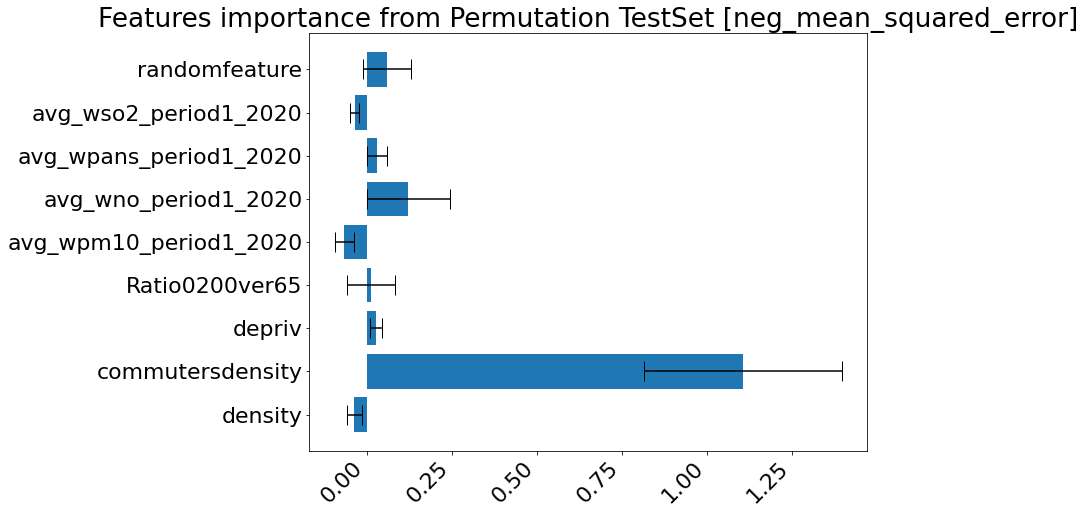

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: -0.02965 +/- 0.01776
Feature:               commutersdensity, Score: 0.88709 +/- 0.23360
Feature:                         depriv, Score: 0.02198 +/- 0.01446
Feature:                 Ratio0200ver65, Score: 0.01059 +/- 0.05723
Feature:         avg_wpm10_period1_2020, Score: -0.05229 +/- 0.02278
Feature:           avg_wno_period1_2020, Score: 0.09821 +/- 0.09823
Feature:         avg_wpans_period1_2020, Score: 0.02388 +/- 0.02295
Feature:          avg_wso2_period1_2020, Score: -0.02790 +/- 0.01066
Feature:                  randomfeature, Score: 0.04851 +/- 0.05679


<Figure size 432x288 with 0 Axes>

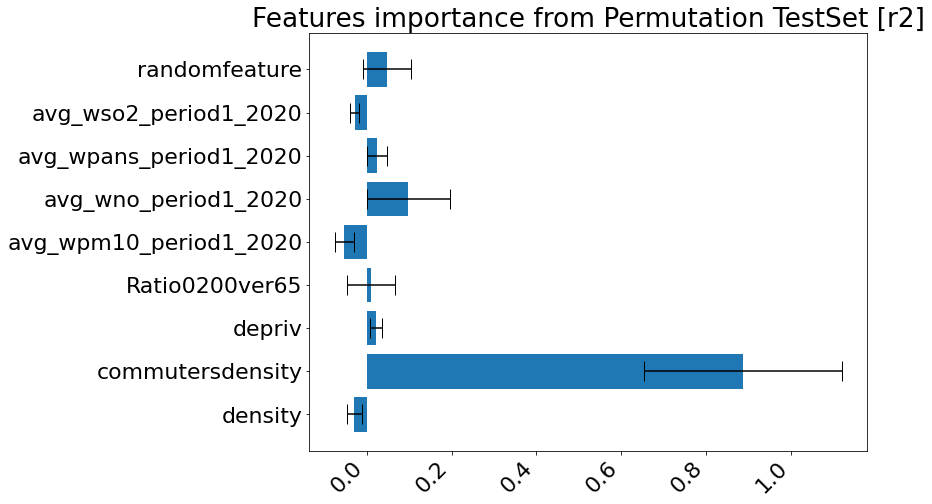

<Figure size 720x720 with 0 Axes>

((0.3895607573909001, 0.027669655836405443),
 (0.9919425762007229, 0.08927252139266684),
 0.3708951032893014,
 {'density': 0.01928653298214163,
  'commutersdensity': 0.6019235743480539,
  'depriv': 0.021029956152730286,
  'Ratio0200ver65': 0.06909195321990087,
  'avg_wpm10_period1_2020': 0.08027112229961825,
  'avg_wno_period1_2020': 0.09590691200048208,
  'avg_wpans_period1_2020': 0.025015016293790805,
  'avg_wso2_period1_2020': 0.024119144966644766,
  'randomfeature': 0.06335578773663747},
 {'density': 0.019286532982141644,
  'commutersdensity': 0.6019235743480537,
  'depriv': 0.0210299561527303,
  'Ratio0200ver65': 0.06909195321990087,
  'avg_wpm10_period1_2020': 0.08027112229961825,
  'avg_wno_period1_2020': 0.09590691200048208,
  'avg_wpans_period1_2020': 0.02501501629379083,
  'avg_wso2_period1_2020': 0.024119144966644794,
  'randomfeature': 0.0633557877366375},
 {'density': -0.030238448253542802,
  'commutersdensity': 0.9048034188555033,
  'depriv': 0.022415970331483605,
  'Rati

In [12]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_nolat", pout=sys.stdout, showplot=True)

In [13]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer_nooverfit (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 Train RMSE:  0.4166919393244559
1  of  1200  Test RMSE:  0.8733221026118262
2  of  1200 Train RMSE:  0.39958512554541054
2  of  1200  Test RMSE:  0.8570768091599654
3  of  1200 Train RMSE:  0.5067513006767722
3  of  1200  Test RMSE:  0.8798384479211473
4  of  1200 Train RMSE:  0.5450872532915004
4  of  1200  Test RMSE:  0.853615908999435
5  of  1200 Train RMSE:  0.7878607515964956
5  of  1200  Test RMSE:  0.8610371560957925
6  of  1200 Train RMSE:  0.8403711877667339
6  of  1200  Test RMSE:  0.888154130431006
7  of  1200 Train RMSE:  0.9558293573888194
7  of  1200  Test RMSE:  0.8799024158760946
8  of  1200 Train RMSE:  0.9965846744411777
8  of  1200  Test RMSE:  0.9260116661058386
9  of  1200 Train RMSE:  0.4949497979918451
9  of  1200  Test RMSE:  0.8807641910456564
10  of  1200 Train RMSE:  0.5148813461249812
10  of  1200  Test RMSE:  0.8573398400792455
11  of  1200 Train RMSE:  0.5336390616539372
11  of  1200  Test RMSE:  0.8800553638404385
12  of  1200 Train RMSE:  0.5

ValueError: too many values to unpack (expected 2)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_nolat_opt", showplot=True, optimisedparams=bestf)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_nolat_nocommut", pout=sys.stdout, showplot=True)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer_nooverfit (X, Y, inboot=[True])

print(bestf, bestmse)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_nolat_nocommut_opt", showplot=True, optimisedparams=bestf)